# Primer analisis de datos exploratorio de Online Retail

En esta notebook se realiza el analisis exploratorio de los datos crudos del dataset de Online Retail. Este dataset contiene los datos de transacciones realizadas en una tienda de retail online britanica sin tienda fisica. 

Segun la pagina del dataset: "Este es un conjunto de datos transaccionales que contiene todas las transacciones que ocurrieron entre el 12/01/2010 y el 12/09/2011 para una tienda minorista en línea no registrada y con sede en el Reino Unido. La empresa vende principalmente regalos únicos para todas las ocasiones."

El objetivo del trabajo es utilizar Clustering con diferentes algoritmos para hacer una analisis de clientes del tipo RFM (Recency, Frequency, Monetary). Luego se deben proponer acciones de marketing personalizadas para al menos tres grupos diferentes.

Vamos a comenzar entonces visualizando algunas instancias del dataset.

In [2]:
import pandas as pd
raw_retail_df = pd.read_excel('../../data/raw_online_retail.xlsx')
raw_retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


El dataset cuenta con 8 features que se describen de la siguiente manera:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

Vamos a verificar los tipos de datos para las columnas.

In [3]:
raw_retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Vamos a verificar que no existan valores nulos en algunas de estas entradas.

In [4]:
raw_retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Hay una gran cantidad de transacciones que no cuentan con el ID del cliente que las realiza. Esto claramente es un problema porque justamente estamos analizando el RFM de los clientes. Veamos algunas instancias de estas transacciones sin cliente.

In [5]:
retail_df = raw_retail_df[raw_retail_df['CustomerID'].notnull()].copy()
null_client_df = raw_retail_df[raw_retail_df['CustomerID'].isnull()].copy()
print(f'Shape de transacciones sin CustomerID: {null_client_df.shape}')
print(f"Cantidad de transacciones sin CustomerID: {null_client_df['CustomerID'].isnull().sum()}")
print(f'Shape de transacciones con CustomerID: {retail_df.shape}')
print(f"Cantidad de transacciones con CustomerID: {retail_df['CustomerID'].notnull().sum()}")
null_client_df.head(10)

Shape de transacciones sin CustomerID: (135080, 8)
Cantidad de transacciones sin CustomerID: 135080
Shape de transacciones con CustomerID: (406829, 8)
Cantidad de transacciones con CustomerID: 406829


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom


Vamos a verificar con el numero de factura si existen otras instancias de la misma compra que tengan el ID del cliente. Si se da esto podemos usar el ID de esa otra instancia en la que tiene ID nulo.

Aunque primero vamos a verificar que cada Invoice corresponda a un unico cliente.

In [6]:
retail_df.groupby('InvoiceNo')['CustomerID'].nunique().value_counts()

CustomerID
1    22190
Name: count, dtype: int64

Todas las facturas tienen unicamente un cliente. Por lo que procedemos a hacer el mapeo.

In [7]:
invoice_to_customer = retail_df.groupby('InvoiceNo')['CustomerID'].first()
null_client_df['CustomerID'] = null_client_df['InvoiceNo'].map(invoice_to_customer)
print(f"Cantidad de transacciones sin CustomerID: {null_client_df['CustomerID'].isnull().sum()}")

Cantidad de transacciones sin CustomerID: 135080


No hubo cambios por lo que directamente podemos dejar de tener en cuenta esas transacciones. Vamos a seguir trabajando con retail_df que no tiene las instancias de cliente nulo.

In [8]:
retail_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Ademas con la eliminacion de esas instancias tambien se eliminaron los valores nulos en Description.

Podemos hacer algunas visualizaciones para ver la naturaleza de los datos.

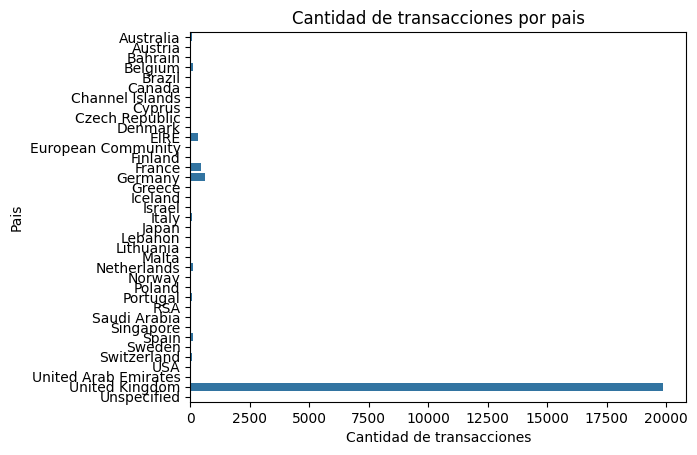

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.barplot(x='InvoiceNo', y='Country', data=retail_df.groupby('Country')['InvoiceNo'].nunique().reset_index())
ax.set_title('Cantidad de transacciones por pais')
ax.set_xlabel('Cantidad de transacciones')
ax.set_ylabel('Pais')
plt.show()

Como era de esperar la mayoria de las compras son de Reino Unido, aunque le siguen paises como Alemania y Francia.

Vamos a ver como se distribuyen los datos de cantidad.

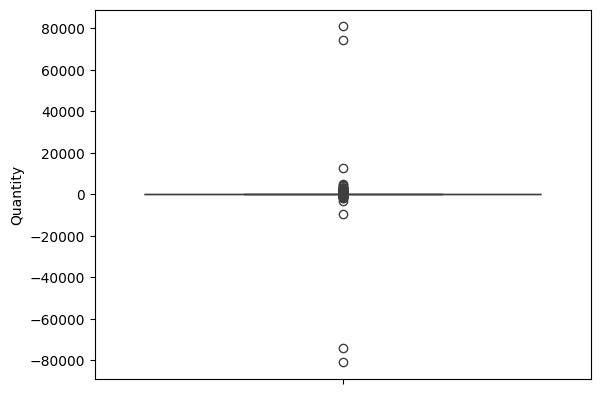

In [11]:
sns.boxplot(retail_df['Quantity'])
plt.show()

Hay algo muy interesante, y es que hay casos en donde contamos con valores de cantidad negativos!

In [12]:
retail_df[retail_df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Como vemos estas instancias corresponden a devoluciones o cancelaciones. Sabemos esto porque el InvoiceNo comienza con la letra C. Vamos a eliminar del dataset todas estas instancias de devolucion que no nos sirven para el analisis de RFM.

In [13]:
retail_df = retail_df[retail_df['Quantity'] > 0]

Y el boxplot ahora se ve asi:

<Axes: ylabel='Quantity'>

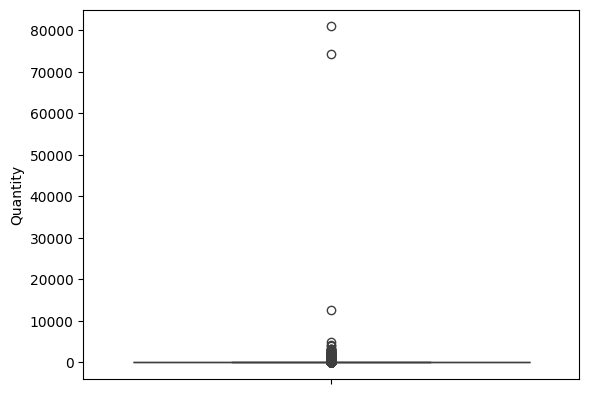

In [14]:
sns.boxplot(retail_df['Quantity'])

Siguen llamando la atencion tres ventas muy por encima del resto. Estamos hablando de los outliers que se ven por arriba de 10000 unidades.

In [15]:
retail_df[retail_df['Quantity'] > 10000].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


No vamos a mentir que el numero de unidades compradas parece extraño. Vamos a ver en total cuantas unidades de estos productos se vendieron.

In [23]:
print(f'Cantidad total de unidades vendidas de cualquier producto: {retail_df["Quantity"].sum()}')
print(f'Cantidad total de unidades vendidas de MEDIUM CERAMIC TOP STORAGE JAR: {retail_df[retail_df["StockCode"] == 23166].Quantity.sum()}')
print(f'Cantidad total de unidades vendidas de ASSTD DESIGN 3D PAPER STICKERS: {retail_df[retail_df["StockCode"] == 84826].Quantity.sum()}')
print(f'Cantidad total de unidades vendidas de PAPER CRAFT , LITTLE BIRDIE: {retail_df[retail_df["StockCode"] == 23843].Quantity.sum()}')

Cantidad total de unidades vendidas de cualquier producto: 5181696
Cantidad total de unidades vendidas de MEDIUM CERAMIC TOP STORAGE JAR: 77916
Cantidad total de unidades vendidas de ASSTD DESIGN 3D PAPER STICKERS: 13702
Cantidad total de unidades vendidas de PAPER CRAFT , LITTLE BIRDIE: 80995
